<a href="https://colab.research.google.com/github/kev461/house-prices-data-science-analysis/blob/main/BD_260220_Houses_prices_Models_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kevin Daniel Alzate Gómez

In [ ]:
#Librerias
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
import tensorflow
from sklearn import cluster

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
#Subida de archivos
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
housesprices = pd.read_csv('train.csv')

In [ ]:
housesprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Data cleaning

In [ ]:
#Manejo de nulos
nuloshousesp=housesprices.isnull().sum()
#Ordenan de maryor a menor
nuloshousesp=nuloshousesp.sort_values(ascending=False)
display(nuloshousesp.head(10))

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageQual,81
GarageFinish,81
GarageType,81


In [ ]:
columnasconmasnulos = nuloshousesp.head(6).index
for col in columnasconmasnulos:
    print(f"Valores únicos para '{col}':")
    display(housesprices[col].unique())
    print("\n" + "-"*50 + "\n")

Valores únicos para 'PoolQC':


array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)


--------------------------------------------------

Valores únicos para 'MiscFeature':


array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)


--------------------------------------------------

Valores únicos para 'Alley':


array([nan, 'Grvl', 'Pave'], dtype=object)


--------------------------------------------------

Valores únicos para 'Fence':


array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)


--------------------------------------------------

Valores únicos para 'MasVnrType':


array(['BrkFace', nan, 'Stone', 'BrkCmn'], dtype=object)


--------------------------------------------------

Valores únicos para 'FireplaceQu':


array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)


--------------------------------------------------



En la documentación los datos con mayores nulos son importantes, ya que indican la presencia de una característica particular de la casa

In [ ]:

housesprices_llenadas = housesprices.copy()

# Llenar nulos con NO para indicar ausencia de algo
for col in columnasconmasnulos:
    if housesprices_llenadas[col].dtype == 'object':
        housesprices_llenadas[col] = housesprices_llenadas[col].fillna("NO")

housesprices_NoNA = housesprices_llenadas.dropna()

display(housesprices_NoNA.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NO,Reg,Lvl,AllPub,...,0,NO,NO,NO,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NO,Reg,Lvl,AllPub,...,0,NO,NO,NO,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NO,IR1,Lvl,AllPub,...,0,NO,NO,NO,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NO,IR1,Lvl,AllPub,...,0,NO,NO,NO,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NO,IR1,Lvl,AllPub,...,0,NO,NO,NO,0,12,2008,WD,Normal,250000


## Categorías pedidas

In [ ]:
#Saber valores unicos de valores de venta de la casa
valormin=housesprices_NoNA['SalePrice'].min()
valormed=housesprices_NoNA['SalePrice'].median()
valormax=housesprices_NoNA['SalePrice'].max()
print(housesprices_NoNA['SalePrice'].min())
print(housesprices_NoNA['SalePrice'].median())
print(housesprices_NoNA['SalePrice'].max())



35311
165750.0
755000


In [ ]:
# Hace falta un valor más para que se hagan los 3 cortes necesarios, así que será con un percentil del 75% para el valor "Alto"
percentil75 = housesprices_NoNA['SalePrice'].quantile(0.75)


bins = [valormin, valormed, percentil75, valormax + 1]
labels = ['Bajo', 'Medio', 'Alto']

#Pandas cut corta los datos en intervalos y se sabe cuales son con "bins", los datos son los bins que YO definí
housesprices_NoNA['SalePriceCategory'] = pd.cut(housesprices_NoNA['SalePrice'], bins=bins, labels=labels, right=False)

#Contar categorías
display(housesprices_NoNA['SalePriceCategory'].value_counts())

# Mostrar columnas del valor con su categoría asociada
display(housesprices_NoNA[['SalePrice', 'SalePriceCategory']].head())

/tmp/ipython-input-2961478211.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housesprices_NoNA['SalePriceCategory'] = pd.cut(housesprices_NoNA['SalePrice'], bins=bins, labels=labels, right=False)


,count
SalePriceCategory,
Bajo,547
Alto,275
Medio,272


,SalePrice,SalePriceCategory
0,208500,Medio
1,181500,Medio
2,223500,Alto
3,140000,Bajo
4,250000,Alto


#Clasificación

In [ ]:
#Aplicar KNN

y = housesprices_NoNA['SalePriceCategory']
X = housesprices_NoNA.drop(['SalePrice', 'SalePriceCategory'], axis=1)


X_encoded = pd.get_dummies(X)


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (875, 282)
Shape of X_test: (219, 282)
Shape of y_train: (875,)
Shape of y_test: (219,)


In [ ]:
neighbors = 15
knnclassifier = KNeighborsClassifier(neighbors)
knnclassifier.fit(X_train, y_train)
knn_predictions = knnclassifier.predict(X_test)

#Precision

accuracyknn = accuracy_score(y_test, knn_predictions)
print("Accuracy:", accuracyknn)
#f1 score

f1knn = f1_score(y_test, knn_predictions, average='weighted')
print("F1 Score:", f1knn)

Accuracy: 0.7442922374429224
F1 Score: 0.739600953034776


In [ ]:
kf = KFold(n_splits=5, shuffle=True)

cv_scores_f1 = cross_val_score(knnclassifier, X_encoded, y, cv=kf, scoring='f1_weighted')

print("F1 de cada fold:", cv_scores_f1)

print("Promedio F1-score:", cv_scores_f1.mean())


F1 de cada fold: [0.71756214 0.7320988  0.68842758 0.72342204 0.7433193 ]
Promedio F1-score: 0.7209659728671304


# Regresión

In [ ]:
#Ya tenemos la DB a usar

y1 = housesprices_NoNA['SalePrice']
X1 = housesprices_NoNA.drop(['SalePrice', 'SalePriceCategory'], axis=1)


Xl_encoded = pd.get_dummies(X1)


Xl_train, Xl_test, yl_train, yl_test = train_test_split(Xl_encoded, y1, test_size=0.2)

print("Shape of X_train:", Xl_train.shape)
print("Shape of X_test:", Xl_test.shape)
print("Shape of y_train:", yl_train.shape)
print("Shape of y_test:", yl_test.shape)

Shape of X_train: (875, 282)
Shape of X_test: (219, 282)
Shape of y_train: (875,)
Shape of y_test: (219,)


## Lasso

In [ ]:

lasso_regressor = Lasso(alpha=1.0,max_iter=50)


lasso_regressor.fit(Xl_train, yl_train)

lasso_predictions = lasso_regressor.predict(Xl_test)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e+11, tolerance: 6.335e+08
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Calcular R2 score
r2 = r2_score(yl_test, lasso_predictions)
print(f"R2 Score: {r2:.4f}")

R2 Score: 0.8780


In [ ]:

# Initialize KFold for cross-validation
kf_regression = KFold(n_splits=5, shuffle=True)

# Initialize Lasso regressor (use the same parameters as before)
lasso_regressor_cv = Lasso(alpha=1, max_iter=500)

# Perform cross-validation with R2 scoring
cv_scores_r2 = cross_val_score(lasso_regressor_cv, Xl_encoded, y1, cv=kf_regression, scoring='r2')

print("R2 por fold Lasso:", cv_scores_r2)
print("Promedio R2 Lasso:", cv_scores_r2.mean())

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e+11, tolerance: 5.709e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e+11, tolerance: 5.800e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.741e+11, tolerance: 6.497e

R2 por fold Lasso: [0.85151077 0.90201763 0.67329727 0.67627741 0.6246901 ]
Promedio R2 Lasso: 0.7455586379255544


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e+11, tolerance: 6.343e+08
  model = cd_fast.enet_coordinate_descent(


## Modelo Regresión

In [ ]:
X_PCA = Xl_encoded.drop(columns=['Id'], errors='ignore')
Y_PCA = housesprices_NoNA['SalePrice']
# Estandarizar
scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X_PCA)

# Dimensionalidad a 1 componente
pca_all = PCA(n_components=1)
X_pca_estandar = pca_all.fit_transform(X_scaled_all)

housesprices_pca0 = housesprices_NoNA.copy()
housesprices_pca0['PCA_1componente'] = X_pca_estandar

housesprices_pca = housesprices_pca0[['PCA_1componente', 'SalePrice']]

print("Columnas luego del PCA:")
display(housesprices_pca[['PCA_1componente', 'SalePrice']].head())

Columnas luego del PCA:


,PCA_1componente,SalePrice
0,3.751898,208500
1,-0.278190,181500
2,4.637005,223500
3,-1.912264,140000
4,6.355955,250000


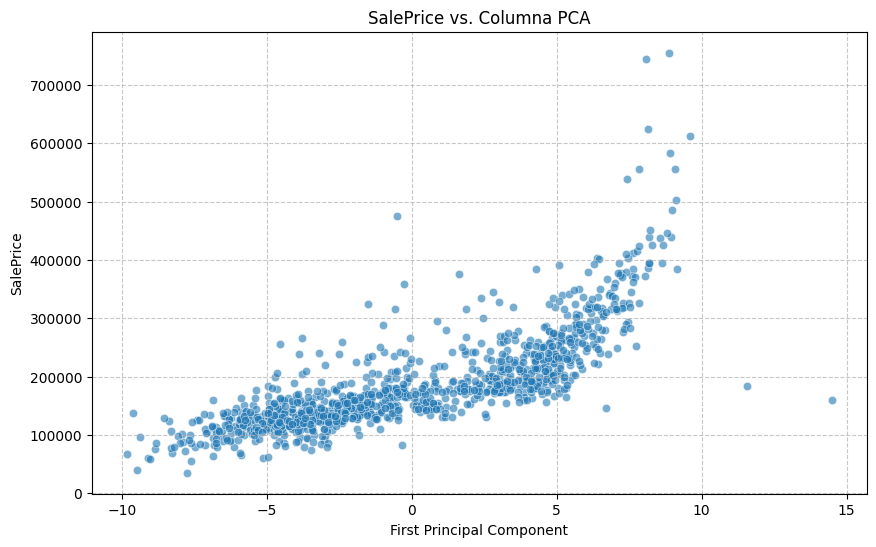

In [ ]:
# PCA con respecto a Valor de Venta
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA_1componente', y='SalePrice', data=housesprices_pca, alpha=0.6)
plt.title('SalePrice vs. Columna PCA')
plt.xlabel('First Principal Component')
plt.ylabel('SalePrice')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

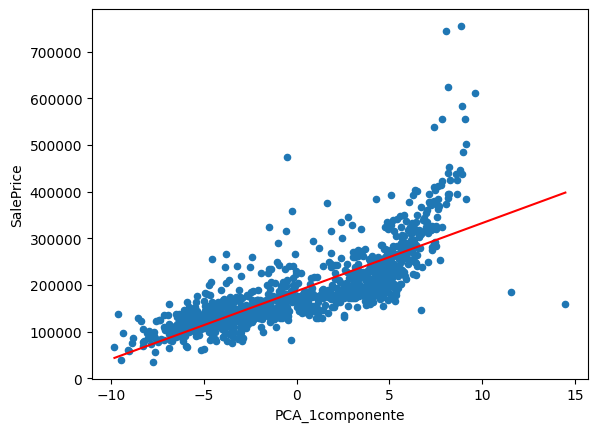

In [ ]:

housesprices_pca.plot.scatter(x='PCA_1componente', y='SalePrice')
a,b = np.polyfit(housesprices_pca.PCA_1componente, housesprices_pca.SalePrice, 1)
x1 = min(housesprices_pca.PCA_1componente)
x2 = max(housesprices_pca.PCA_1componente)
plt.plot([x1,x2], [a*x1 + b, a*x2 + b], color='red')
plt.show()

In [ ]:
#Valor correlación
r = np.corrcoef(housesprices_pca.PCA_1componente, housesprices_pca.SalePrice)[1,0]
print('Relación coeficiente PCA_1componente Vs SalePrice:', r)
r = np.corrcoef(housesprices_pca.SalePrice, housesprices_pca.PCA_1componente)[1,0]
print('Relación coeficiente SalePrice Vs PCA_1componente:', r)

Relación coeficiente PCA_1componente Vs SalePrice: 0.7805275185976366
Relación coeficiente SalePrice Vs PCA_1componente: 0.7805275185976366


In [ ]:
Xl_trainPCA, Xl_testPCA, yl_trainPCA, yl_testPCA = train_test_split(housesprices_pca.PCA_1componente, Y_PCA, test_size=0.2)



Training data:


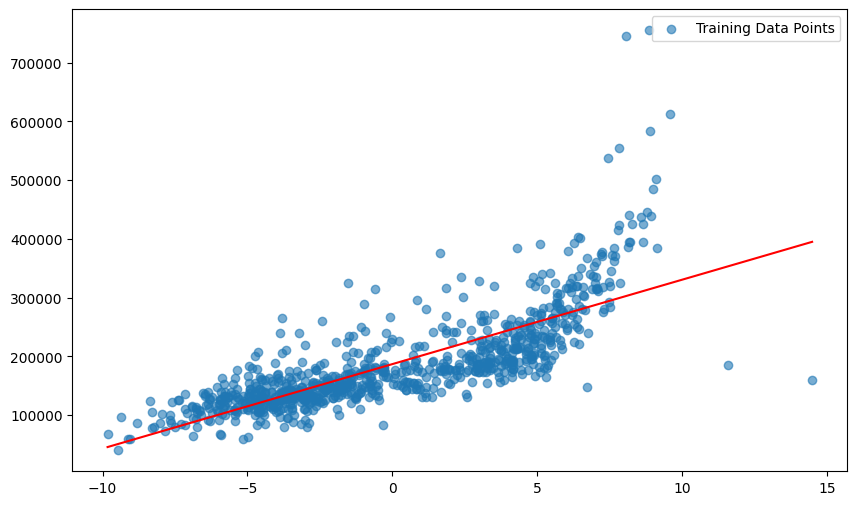

In [ ]:

a,b = np.polyfit(Xl_trainPCA, yl_trainPCA, 1)

print('Training data:')


plt.figure(figsize=(10, 6))
plt.scatter(Xl_trainPCA, yl_trainPCA, alpha=0.6, label='Training Data Points')

x1 = min(Xl_trainPCA)
x2 = max(Xl_trainPCA)
plt.plot([x1,x2], [a*x1 + b, a*x2 + b], color='red')
plt.legend()
plt.show()

In [ ]:
#Calcular
predicted_saleprice = a * Xl_testPCA + b

print('Precios Predichos:')
display(predicted_saleprice.head())

print('\nPrecios reales:')
display(yl_testPCA.head())

Precios Predichos:


,PCA_1componente
771,107256.209634
397,174154.169595
753,257042.273976
1087,256073.697327
137,191470.360340



Precios reales:


,SalePrice
771,102000
397,169500
753,275500
1087,252000
137,171000


# Decission Tree

## DCT Classifier

In [ ]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)


DecisionTreeClassifier()

In [ ]:
dtc_predictions = dtc.predict(X_test)
accuracy_dtc = accuracy_score(y_test, dtc_predictions)
f1_dtc = f1_score(y_test, dtc_predictions, average='weighted')
print(f"Decision Tree Accuraccy: {accuracy_dtc}")
print(f"Decision Tree Accuraccy: {f1_dtc}")

Decision Tree Accuraccy: 0.817351598173516
Decision Tree Accuraccy: 0.8191012604839786


In [ ]:
#SKF Decission tree

# Initialize KFold for cross-validation
kf_dtc = KFold(n_splits=5, shuffle=True)

# Perform cross-validation with F1-weighted scoring
cv_scores_f1_dtc = cross_val_score(dtc, X_encoded, y, cv=kf_dtc, scoring='f1_weighted')

print("F1 para cada fold::", cv_scores_f1_dtc)
print("F1 promedio:", cv_scores_f1_dtc.mean())

F1 para cada fold:: [0.79725304 0.80134473 0.78228894 0.80720101 0.76449895]
F1 promedio: 0.7905173337336383


## Decision Tree for Regression

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

dtr.fit(Xl_train, yl_train)



DecisionTreeRegressor()

In [ ]:
dtr_predictions = dtr.predict(Xl_test)

r2_dtr = r2_score(yl_test, dtr_predictions)

print(f"Decision Tree Regressor R2: {r2_dtr}")


Decision Tree Regressor R2: 0.7467982959231649


In [ ]:
# SKF
kf_dtr = KFold(n_splits=5, shuffle=True)

# Con R2 para clasificar
cv_scores_r2_dtr = cross_val_score(dtr, Xl_encoded, y1, cv=kf_dtr, scoring='r2')

print("R2 para cada fold:", cv_scores_r2_dtr)
print("R2 promedio:", cv_scores_r2_dtr.mean())

R2 para cada fold: [0.77956173 0.72313339 0.79889449 0.77624564 0.65563567]
R2 promedio: 0.7466941851907001


## Comparar modelos de clasificación




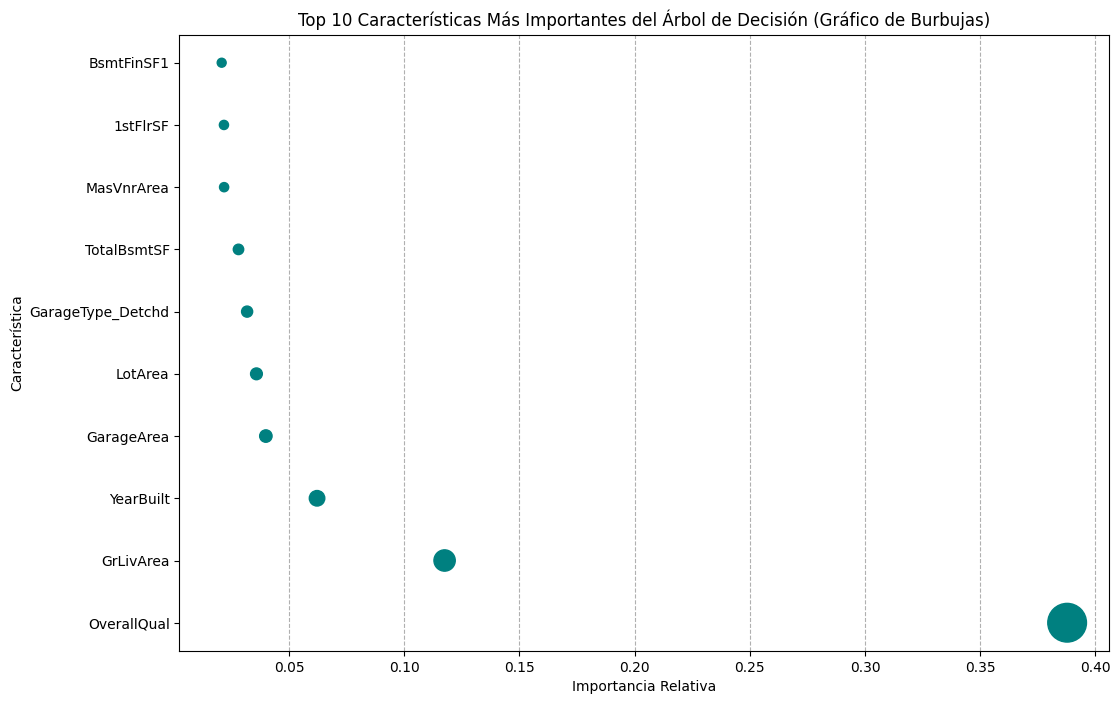

In [ ]:
importances = dtc.feature_importances_
nombrescol = X_encoded.columns

trees_importances = pd.Series(importances, index=nombrescol)

# Obtener las 10 características más importantes
top_10_features = trees_importances.nlargest(10)

plt.figure(figsize=(12, 8))
# Escalar la importancia para que el tamaño de los puntos sea visible
scaled_importances = top_10_features.values * 2000  # Multiplicar por un factor para hacer los puntos visibles

# Crear el gráfico de dispersión
plt.scatter(x=top_10_features.values, y=top_10_features.index, s=scaled_importances, color='teal')
plt.title('Top 10 Características Más Importantes del Árbol de Decisión (Gráfico de Burbujas)')
plt.xlabel('Importancia Relativa')
plt.ylabel('Característica')
plt.grid(axis='x', linestyle='--')
plt.show()

In [ ]:
clasificar_metricas = {
    'Modelo': ['K-Nearest Neighbors', 'Decision Tree Classifier'],
    'Accuracy': [accuracyknn, accuracy_dtc],
    'F1-Score': [f1knn, f1_dtc]
}

metrics_df = pd.DataFrame(clasificar_metricas)
display(metrics_df)

,Modelo,Accuracy,F1-Score
0,K-Nearest Neighbors,0.744292,0.739601
1,Decision Tree Classifier,0.817352,0.819101


In [ ]:
r2_pca_linear = r2_score(yl_testPCA, predicted_saleprice)
print(f"R2 Score for PCA with Linear Regression: {r2_pca_linear:.4f}")

R2 Score for PCA with Linear Regression: 0.6220


In [ ]:
rmetricas_regresion = {
    'Modelo': ['Lasso Regression', 'Decision Tree Regressor', 'PCA Lineal'],
    'R2-Score': [r2, r2_dtr, r2_pca_linear]
}

regression_df = pd.DataFrame(rmetricas_regresion)
display(regression_df)

,Modelo,R2-Score
0,Lasso Regression,0.878012
1,Decision Tree Regressor,0.746798
2,PCA Lineal,0.621972


Clasificación: El Árbol de Decisión superó significativamente a K-Nearest Neighbors, con una precisión del 0.8173 y un F1-score del 0.8191. KNN obtuvo una precisión de 0.7442 y un F1-score de 0.7396.

Regresión: Lasso Regression fue el mejor modelo, alcanzando el R2-score más alto con 0.8780. El Regresor de Árbol de Decisión le siguió con un R2-score de 0.7467. PCA con Regresión Lineal obtuvo el R2-score más bajo con 0.6219.

Conclusión General: Para la clasificación, el Árbol de Decisión es el modelo con mejor rendimiento. Para la regresión, Lasso Regression es el modelo superior.

# Visualizaciones

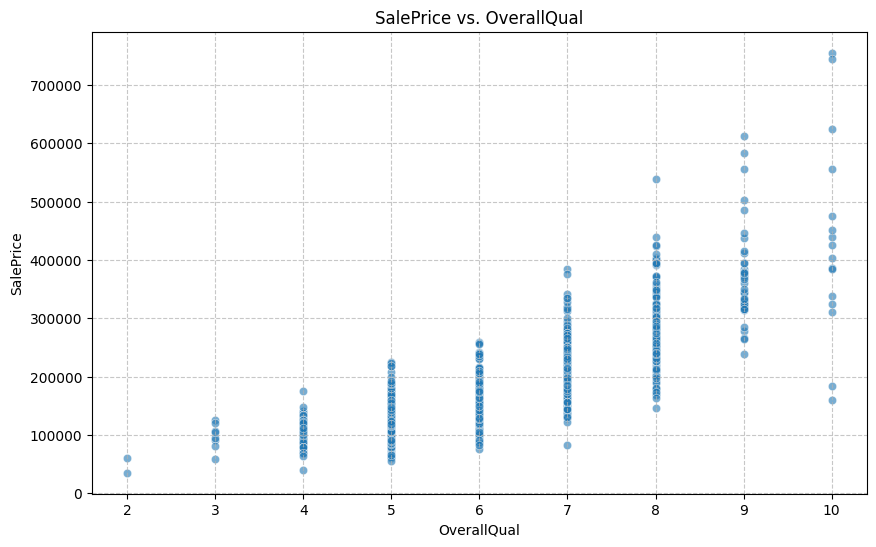

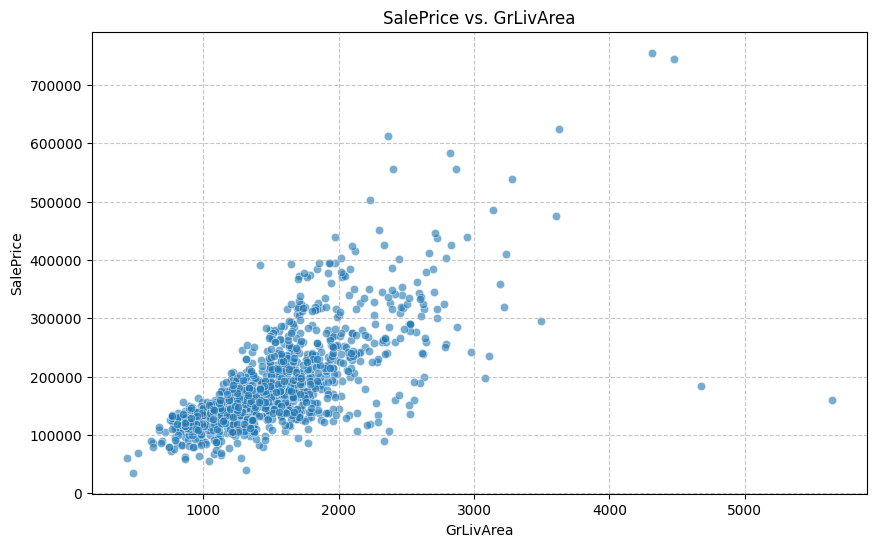

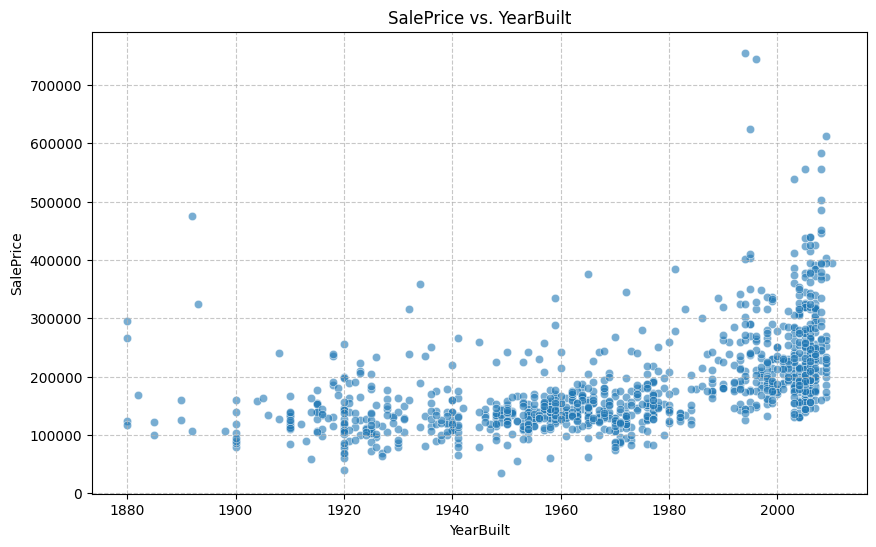

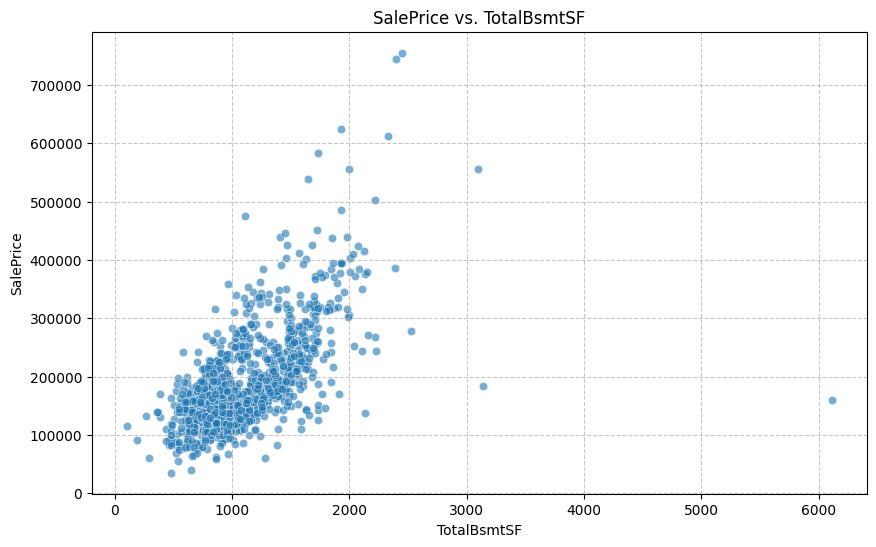

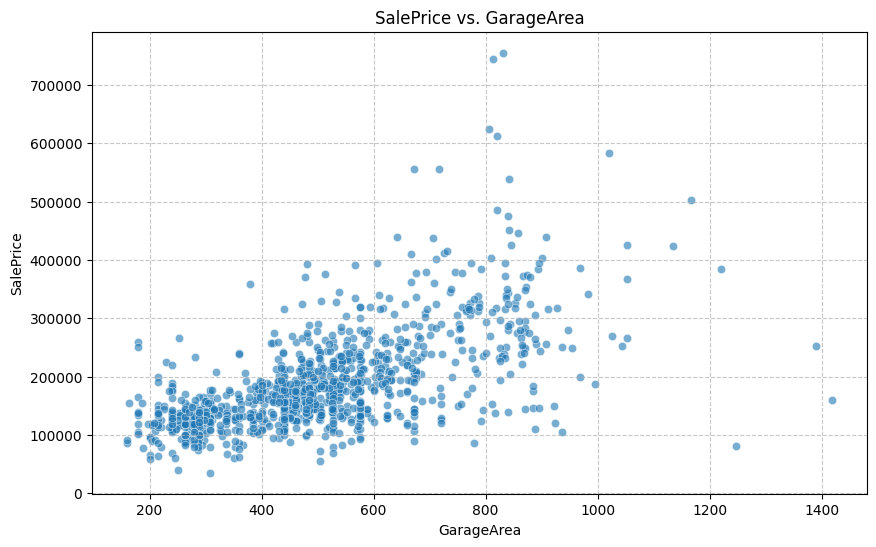

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Se hará con las 5 más importantes que se sacaron de random forest
top_features = ['OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageArea']


for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature, y='SalePrice', data=housesprices_NoNA, alpha=0.6)
    plt.title(f'SalePrice vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

Predicción con Lasso



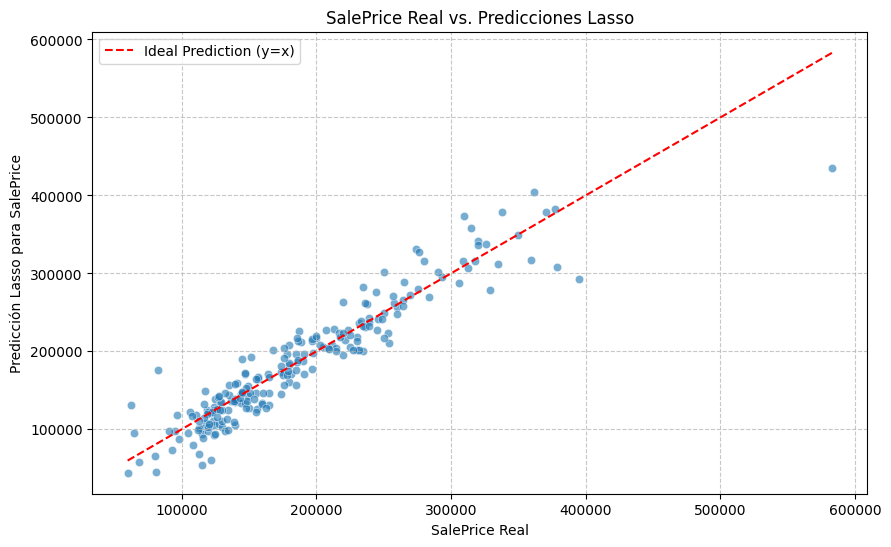

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=yl_test, y=lasso_predictions, alpha=0.6)
plt.plot([min(yl_test), max(yl_test)], [min(yl_test), max(yl_test)], color='red', linestyle='--', label='Ideal Prediction (y=x)')
plt.title('SalePrice Real vs. Predicciones Lasso')
plt.xlabel('SalePrice Real')
plt.ylabel('Predicción Lasso para SalePrice')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Visualización de Predicciones del Decision Tree Regressor

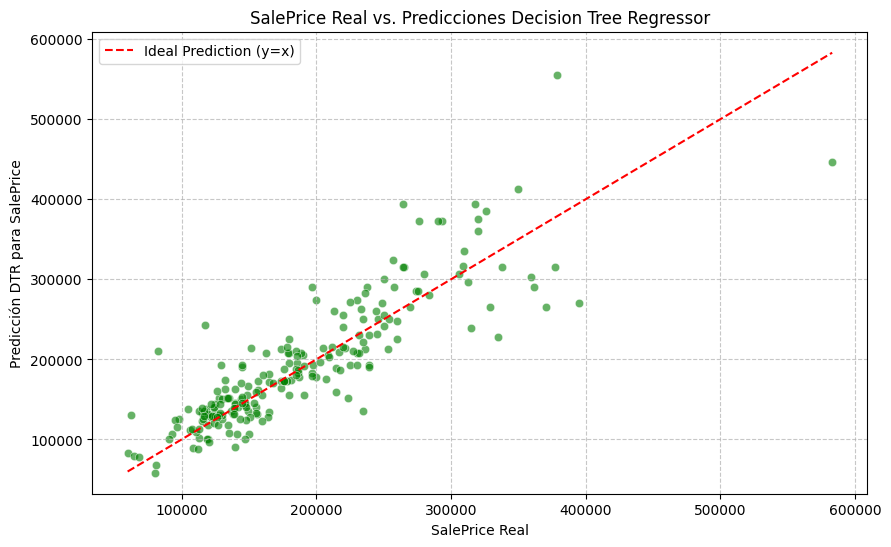

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=yl_test, y=dtr_predictions, alpha=0.6, color='green')
plt.plot([min(yl_test), max(yl_test)], [min(yl_test), max(yl_test)], color='red', linestyle='--', label='Ideal Prediction (y=x)')
plt.title('SalePrice Real vs. Predicciones Decision Tree Regressor')
plt.xlabel('SalePrice Real')
plt.ylabel('Predicción DTR para SalePrice')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Visualización de Predicciones de PCA con Regresión Lineal

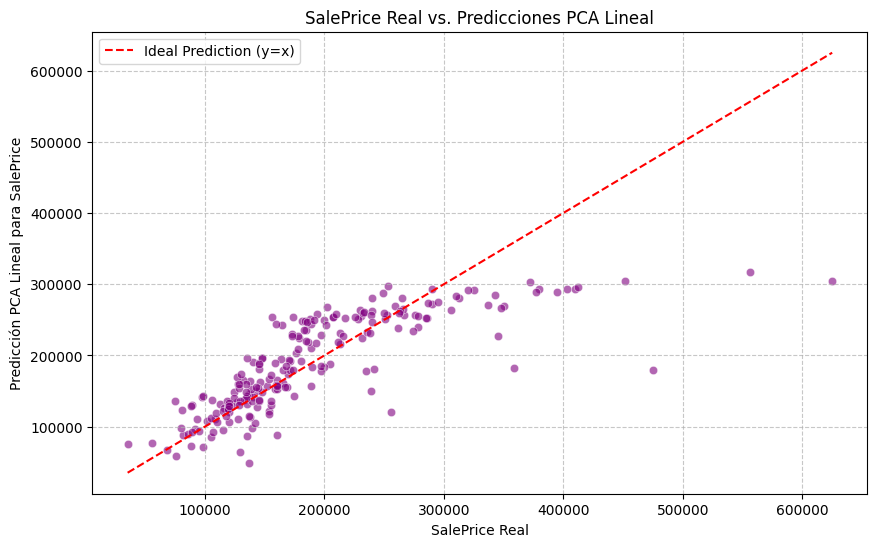

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=yl_testPCA, y=predicted_saleprice, alpha=0.6, color='purple')
plt.plot([min(yl_testPCA), max(yl_testPCA)], [min(yl_testPCA), max(yl_testPCA)], color='red', linestyle='--', label='Ideal Prediction (y=x)')
plt.title('SalePrice Real vs. Predicciones PCA Lineal')
plt.xlabel('SalePrice Real')
plt.ylabel('Predicción PCA Lineal para SalePrice')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Visualización de Predicciones de Clasificación - K-Nearest Neighbors

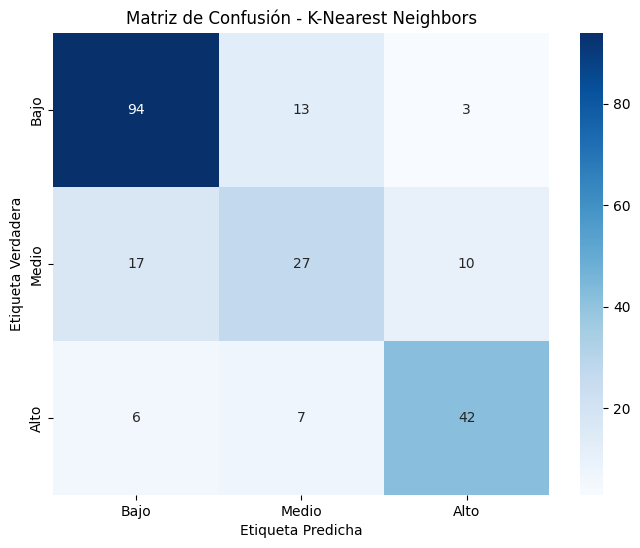

In [ ]:
# Matriz de confusión para KNN
cm_knn = confusion_matrix(y_test, knn_predictions, labels=['Bajo', 'Medio', 'Alto'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, cmap='Blues', xticklabels=['Bajo', 'Medio', 'Alto'], yticklabels=['Bajo', 'Medio', 'Alto'])
plt.title('Matriz de Confusión - K-Nearest Neighbors')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()


Visualización de Predicciones de Clasificación - Decision Tree Classifier

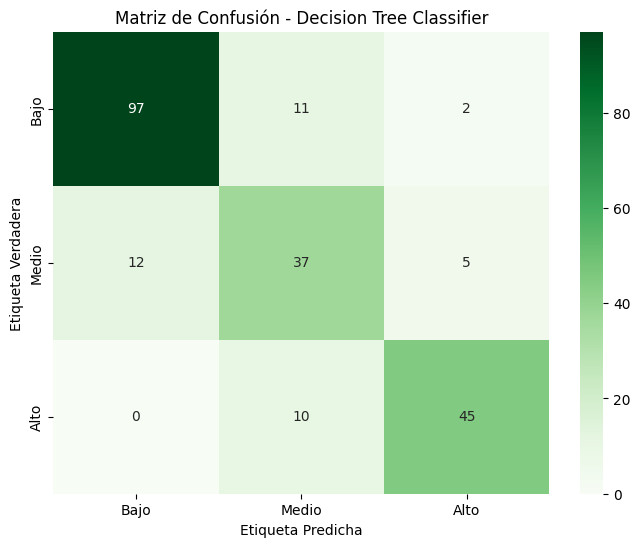

In [ ]:
# Matriz de confusión para Decision Tree Classifier
cm_dtc = confusion_matrix(y_test, dtc_predictions, labels=['Bajo', 'Medio', 'Alto'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dtc, annot=True, cmap='Greens', xticklabels=['Bajo', 'Medio', 'Alto'], yticklabels=['Bajo', 'Medio', 'Alto'])
plt.title('Matriz de Confusión - Decision Tree Classifier')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()
